In [8]:
import torch, torch.nn as nn, torch.utils.data as data, torchvision as tv, torch.nn.functional as F
import lightning as L
import numpy as np


class Learner(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x);

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=.001)
        return optimizer

In [9]:
class Dataset(data.Dataset):

    def __init__(self, init, end, n):

        self.n = n
        #self.x = np.random.rand(self.n, 1) * (end - init) + init
        self.x = torch.linspace(init, end, self.n)
        self.y = np.exp(self.x)

    def __len__(self):

        return self.n

    def __getitem__(self, idx):

        x = self.x[idx, np.newaxis]
        y = self.y[idx, np.newaxis]

        return torch.Tensor(x), torch.Tensor(y)

In [10]:
train = Dataset(-np.pi * 2, np.pi * 2, 1000)

In [11]:
net = nn.Sequential(
        nn.Linear(1, 20),
        nn.ELU(),
        nn.Linear(20, 50),
        nn.ELU(),
        nn.Linear(50, 50),
        nn.ELU(),
        nn.Linear(50, 1)
    )
net

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=20, out_features=50, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=50, out_features=1, bias=True)
)

In [12]:
trainer = L.Trainer(logger=False, max_epochs=1000)
learner = Learner(net)
trainer.fit(learner, data.DataLoader(train, batch_size=20))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 3.7 K 
-------------------------------------
3.7 K     Trainable params
0         Non-trainable params
3.7 K     Total params
0.015     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1000` reached.


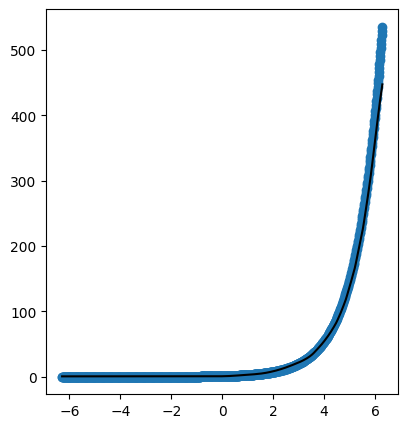

In [14]:
import matplotlib.pyplot as plt

y_hat = learner.model.forward(train.x.view(1000, 1))
y_hat = y_hat.detach().cpu()
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.plot(train.x, y_hat, color='black')
ax.scatter(train.x, train.y)